In [1]:
import pandas as pd
import os
import opendatasets as od
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import cv2 as cv
import random as rnd

### Downloading Dataset

In [2]:
dataset = 'https://www.kaggle.com/datasets/anshtanwar/jellyfish-types'

In [12]:
#od.download(dataset)

There were 7 folders, but I removed 2. The project calls for 5 classes of the target variable. I removed the mauve class and the folder train_test_valid which took images from the other 6 folders and split them up. There were too few images in those folders. I'll just do the split myself.

### Loading Data

In [3]:
os.listdir('jellyfish-types')

['compass_jellyfish',
 'Moon_jellyfish',
 'blue_jellyfish',
 'lions_mane_jellyfish',
 'barrel_jellyfish']

In [4]:
fish = os.listdir('jellyfish-types')

In [5]:
data_dir = 'jellyfish-types/'

There are 150 images for each type of jellyfish. The below code shows 150, 150, 148, 148, 150 because JFIF function below removes four images and so re-running this code shows them as having been removed.

In [6]:
for i in range(len(fish)):
    print(len(os.listdir(data_dir + fish[i])))

147
150
145
148
147


Gets directories for each type of jellyfish.

In [7]:
def get_class_directories():
    class_directories = []
    for category in fish:
        class_directories = class_directories + ['jellyfish-types/{}/'.format(category)]
    return class_directories

In [8]:
get_class_directories()

['jellyfish-types/compass_jellyfish/',
 'jellyfish-types/Moon_jellyfish/',
 'jellyfish-types/blue_jellyfish/',
 'jellyfish-types/lions_mane_jellyfish/',
 'jellyfish-types/barrel_jellyfish/']

Gets the .jpgs for the images in each folder and makes a single list.

In [9]:
def get_jpgs():
    jpgs = []
    for cd in get_class_directories():
        for i in range(len(os.listdir(cd))):
            jpgs.append(cd + os.listdir(cd)[i])
    return jpgs

##### Removing Corrupt Images  
  
Checks for JFIF in .jpg and removes if JFIF isn't there.

In [10]:
def jfif():
    num_skipped = 0
    indexes = []
    jpgs = get_jpgs()
    for i in range(len(jpgs)):
        try:
            fobj = open(jpgs[i], 'rb')
            is_jfif = b"JFIF" in fobj.peek(10)
        finally:
            fobj.close()
        
        if not is_jfif:
            num_skipped += 1
            os.remove(jpgs[i])
            indexes.append(i)
    return num_skipped, indexes

In [11]:
#jfif()

Four corrupted images out of 750 total were removed. Two were blue jellyfish and two were lions mane jellyfish.

Makes list of labels corresponding to list of .jpgs.

In [13]:
def get_labels():
    labels = []
    jpgs = get_jpgs()
    for i in range(len(jpgs)):
        if 'compass' in jpgs[i]:
            labels.append('compass')
        elif 'Moon' in jpgs[i]:
            labels.append('Moon')
        elif 'blue' in jpgs[i]:
            labels.append('blue')
        elif 'lions_mane' in jpgs[i]:
            labels.append('lions_mane')
        elif 'barrel' in jpgs[i]:
            labels.append('barrel')
    return labels

In [14]:
labels = get_labels()

In [15]:
labels = np.asarray(labels)

### Visualizing Images

In [16]:
def show_imgs(indexes):
    jpgs = get_jpgs()
    for index in indexes:
        data = plt.imread(jpgs[index])
        plt.imshow(data)
        plt.title('{}'.format(labels[index]))
        plt.show()

##### Visualizing One of Each Jellyfish Type

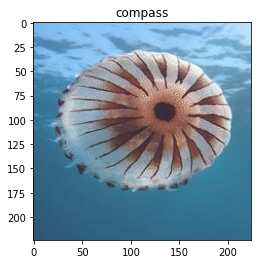

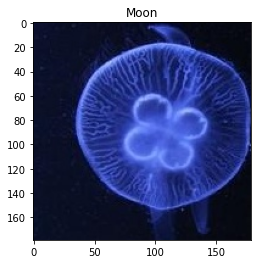

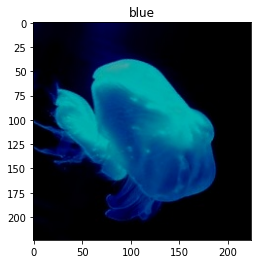

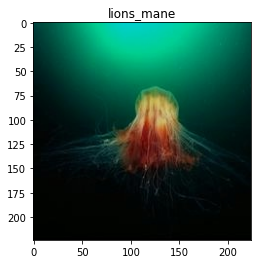

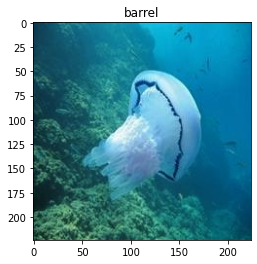

In [17]:
show_imgs([25, 175, 325, 475, 625])

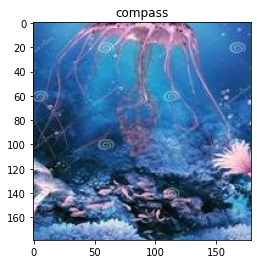

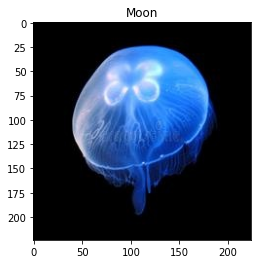

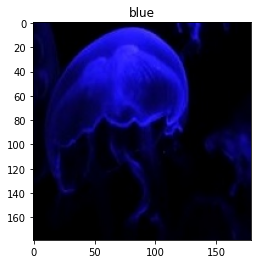

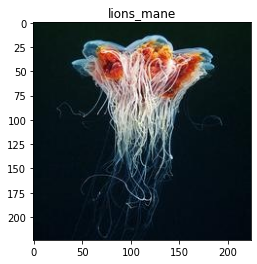

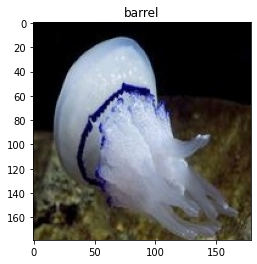

In [19]:
show_imgs([50, 200, 350, 500, 650])

### More Data Preprocessing  
  
  The functions below resize the image and calculate the RGB pixel means for each image. The last function determines which images have outlier R, G, or B mean values. The idea is to determine if any of the images left after removing corrupt images are bad images that need to be removed.

In [18]:
def resize(img, size):
    return cv.resize(img, size)

def get_pixel_means():
    jpgs = get_jpgs()
    means = []
    for i in range(len(jpgs)):
        img_data = plt.imread(jpgs[i])
        img_data = resize(img_data, (224, 224))
        means.append(np.mean(np.mean(img_data, axis = 1), axis = 0))
    return pd.DataFrame(means, columns = ['r_means', 'g_means', 'b_means'])

def rgb_mean_outliers(r_means, g_means, b_means):
    rmean, gmean, bmean = r_means.mean(), g_means.mean(), b_means.mean()
    rstd, gstd, bstd = np.std(r_means), np.std(g_means), np.std(b_means)
    threshold = 3
    r_outliers, g_outliers, b_outliers = [], [], []
    r_indexes, g_indexes, b_indexes = [], [], []
    for i in range(len(r_means)):
        rz_score = (r_means[i] - rmean) / rstd
        gz_score = (g_means[i] - gmean) / gstd
        bz_score = (b_means[i] - bmean) / bstd
        if abs(rz_score > threshold):
            r_outliers.append(r_means[i])
            r_indexes.append(i)
        if abs(gz_score > threshold):
            g_outliers.append(g_means[i])
            g_indexes.append(i)
        if abs(bz_score > threshold):
            b_outliers.append(b_means[i])
            b_indexes.append(i)
    return r_outliers, r_indexes, g_outliers, g_indexes, b_outliers, b_indexes

##### Detecting Bad Images: RGB Outliers  
  
Using the mean RGB values for each image to find outlier images and see if they need to be removed. There weren't any.

In [29]:
means_df = get_pixel_means()

In [30]:
r_outliers, r_indexes, g_outliers, g_indexes, b_outliers, b_indexes= rgb_mean_outliers(means_df['r_means'],
                                                                                      means_df['g_means'],
                                                                                      means_df['b_means'])

In [31]:
r_outliers, r_indexes

([219.24491788903057, 198.70802774234696], [318, 344])

In [32]:
g_outliers, g_indexes

([240.1607940051021], [625])

In [33]:
b_outliers, b_indexes

([], [])

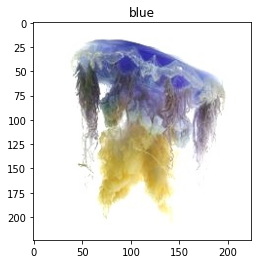

In [34]:
r_outlier1 = plt.imread(get_jpgs()[318])
plt.imshow(r_outlier1)
plt.title(labels[318])
plt.show()

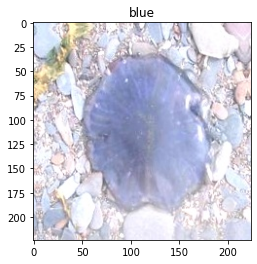

In [36]:
r_outlier2 = plt.imread(get_jpgs()[344])
plt.imshow(r_outlier2)
plt.title(labels[344])
plt.show()

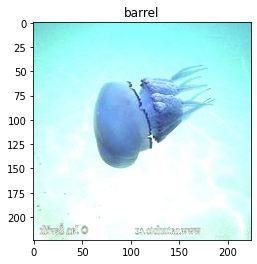

In [40]:
g_outlier1 = plt.imread(get_jpgs()[625])
plt.imshow(g_outlier1)
plt.title(labels[625])
plt.show()

##### Detecting Bad Images: Edge Density Outliers  
  
The goal here was to find images that may need to be removed by taking one element of image data and checking outliers. The result was finding multiple images that appear to be duplicate images, but one of them was augmented in some way. Augmentation will be done on all images before building a second model, so these duplicates will be removed. At least the ones that were found. They seem to be rare relative to the overall dataset, but a few came up with the edge density outliers.

In [74]:
def edge_density():
    jpgs = get_jpgs()
    densities = []
    for i in range(len(jpgs)):
        img = cv.imread(jpgs[i], cv.IMREAD_GRAYSCALE)
        img = resize(img, (224, 224))
        assert img is not None, "file could not be read, check with os.path.exists()"
        edges = cv.Canny(img, 50, 150)
        edge_counts = np.sum(edges > 0)
        edge_density = edge_counts / (edges.shape[0] * edges.shape[1])
        densities.append(edge_density)
    return densities

def density_outliers(densities):
    mean = np.mean(densities)
    std = np.std(densities)
    threshold = 3
    outliers = []
    indexes = []
    for i in range(len(densities)):
        z_score = (densities[i] - mean) / std
        if abs(z_score) > threshold:
            outliers.append(densities[i])
            indexes.append(i)
    return outliers, indexes

In [44]:
edge_densities = edge_density()

In [46]:
edge_outliers, edge_indexes = density_outliers(edge_densities)

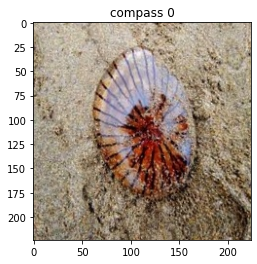

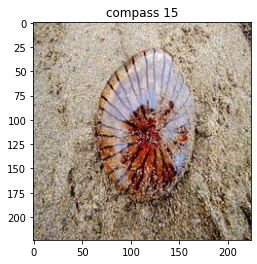

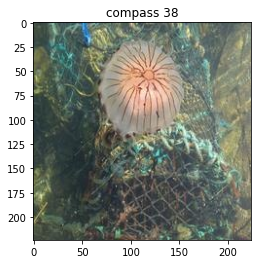

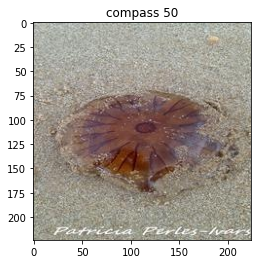

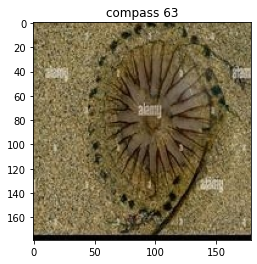

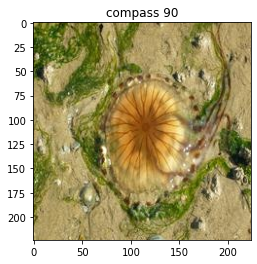

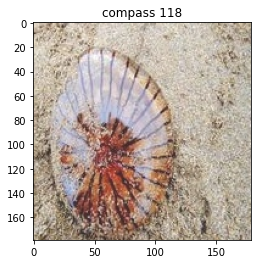

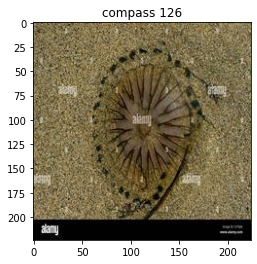

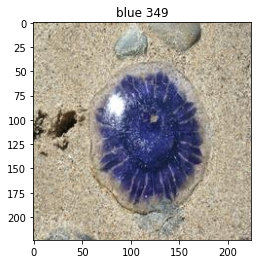

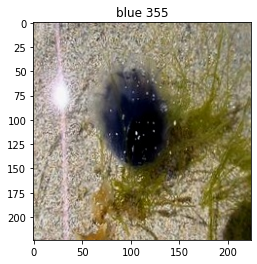

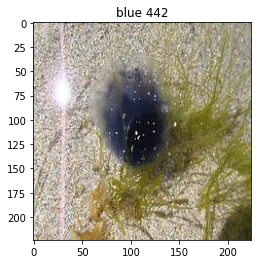

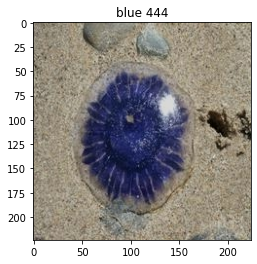

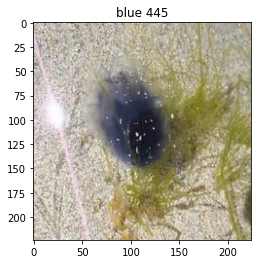

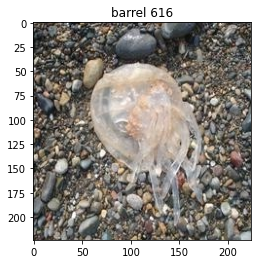

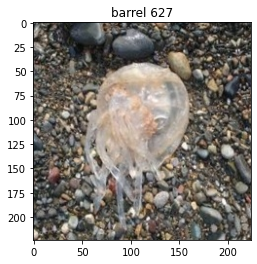

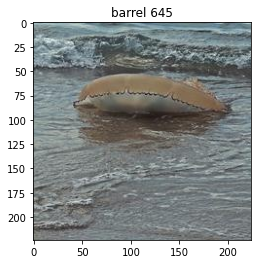

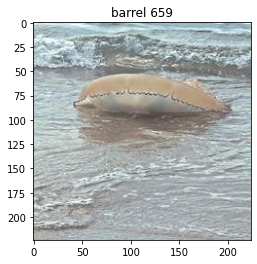

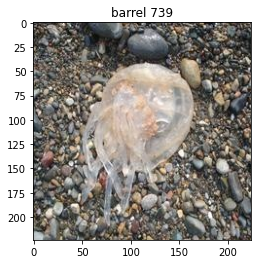

In [50]:
for i in edge_indexes:
    data = plt.imread(get_jpgs()[i])
    plt.imshow(data)
    plt.title(labels[i] + ' {}'.format(i))
    plt.show()

There are multiple images that are duplicates with slight augmentations. I've removed the extras with the code below.

In [51]:
def remove(duplicates):
    jpgs = get_jpgs()
    for i in duplicates:
        os.remove(jpgs[i])

In [52]:
remove([15, 118, 126, 442, 444, 445, 627, 659, 739])

In [53]:
len(get_jpgs())

737

In [71]:
labels = get_labels()